In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic
import pandas as pd, numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pdb as pdb

In [3]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Purple, CB91_Green, CB91_Amber, CB91_Blue, CB91_Pink, CB91_Violet]
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [4]:
def get_df(arr):
    sim_df = pd.DataFrame(arr, columns=['CodeGen','CodeTrans','CodeSumm','CodeRef'])
    sim_df = sim_df * 100
    sim_df = sim_df.round(2)
    sim_df['tasks'] = ['CodeGen','CodeTrans','CodeSumm','CodeRef']
    sim_df.set_index('tasks', inplace=True)
    return sim_df

def plot_heatmap(data, title, savename=None, vmin=None, vmax=None):

    params = {"lines.linewidth": 1.1, "font.size":14, "axes.titlesize":18, 
            "axes.labelsize":20, 'xtick.labelsize':14, 'ytick.labelsize':14,
            'legend.fontsize': 12, 'legend.labelspacing': 0.3, 'legend.handletextpad': 0.2,
            'legend.borderpad': 0.4}
    sns.set(style="ticks", rc=params)

    ax = sns.heatmap(data, annot=True, fmt='.1f', linewidths=.5, cmap="YlGnBu", vmin=vmin, vmax=vmax)
    ax.set(ylabel=r'', xlabel=r'')
    ax.set_title(f'{title}')
    ax.set_aspect('auto')
    if savename is not None:
        plt.savefig(f'./figures/{savename}.pdf', dpi=1000,  bbox_inches='tight')
    else:
        plt.show()

def plot_freq_counts(data_df, title='', savename=None):
    color_list = [CB91_Purple, CB91_Green, CB91_Blue, CB91_Pink, CB91_Amber, CB91_Violet, 'k']
    plots = []
    nrows, ncols = 2, 3
    fig, axes = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(5*ncols,4*nrows), dpi=400)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.3)
    fig.suptitle(f'{title}')
    y_names = ['CodeGen','CodeTrans','CodeSumm','CodeRef']

    for y_i, y_name in enumerate(y_names):
        plots.append(sns.barplot(ax=axes[y_i//ncols, y_i%ncols],
                    x="Prompt_id", y=y_name, data=data_df, color=color_list[y_i]))

    plots.append(sns.barplot(ax=axes[1, 1],
                x="Prompt_id", y='All', data=data_df, color=color_list[-1]))
    
    for plot in plots:
        for ind, label in enumerate(plot.get_xticklabels()):
            if ind % 10 == 0:  # every 10th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    
    if savename is not None:
        plt.savefig(f'./figures/{savename}.pdf', dpi=1000,  bbox_inches='tight')
    else:
        plt.show()
    
def get_intersection_stats(data, noise_perc_thresh, noise_exact_thresh=20):
    tasks = ['CodeGen','CodeTrans','CodeSumm','CodeRef']
    common_union = np.zeros((len(tasks), len(tasks)))
    common_all = np.zeros((len(tasks), len(tasks)))

    for i, task_i in enumerate(tasks):
        for j, task_j in enumerate(tasks):
            arr_i = np.array(data[task_i])
            arr_j = np.array(data[task_j])
            thresh_i = min(int(arr_i.sum() * noise_perc_thresh), noise_exact_thresh)
            thresh_j = min(int(arr_j.sum() * noise_perc_thresh), noise_exact_thresh)
            # print(arr_i.sum(), arr_j.sum())
            used_i = np.where(arr_i > thresh_i)[0]
            used_j = np.where(arr_j>thresh_j)[0]
            intersect_over_union = len(np.intersect1d(used_i, used_j)) / len(np.union1d(used_i, used_j))
            intersect_over_all = len(np.intersect1d(used_i, used_j)) / len(arr_i)
            common_union[i,j] = intersect_over_union
            common_all[i,j] = intersect_over_all
    return common_union, common_all

def get_count_df(counts, noise_perc_thresh, noise_exact_thresh):
    (sparse_freq_overlap, dense_freq_overlap) = get_intersection_stats(counts, noise_perc_thresh, noise_exact_thresh)
    sparse_freq_overlap_df = get_df(sparse_freq_overlap)
    dense_freq_overlap_df = get_df(dense_freq_overlap)
    return sparse_freq_overlap, dense_freq_overlap

## Query Conicity analysis

In [30]:
query_pool = np.array([[0.9999896287918091, 0.9999616146087646, 0.9999662637710571, 0.9999593496322632], [0.9999616742134094, 0.9999867677688599, 0.9999721050262451, 0.9999745488166809], [0.9999662041664124, 0.9999721050262451, 0.9999886155128479, 0.9999811053276062], [0.999959409236908, 0.9999744892120361, 0.9999811053276062, 0.9999938011169434]])
query_pool_shared_proj = np.array([[1.0, 0.9999985694885254, 0.9999997615814209, 0.9999992251396179], [0.9999986886978149, 0.9999995231628418, 0.9999989867210388, 0.9999977350234985], [0.9999998807907104, 0.9999989867210388, 1.0, 0.9999995231628418], [0.9999991655349731, 0.9999977946281433, 0.9999995231628418, 1.0]])
query_pool_sep_proj = np.array([[0.9999989867210388, -0.5306833982467651, 0.9334725141525269, -0.8308905363082886], [-0.5306833982467651, 0.7215512990951538, -0.5502617359161377, 0.5273928642272949], [0.9334726333618164, -0.5502617359161377, 1.0, -0.9124571681022644], [-0.8308907151222229, 0.5273928046226501, -0.9124572277069092, 1.0]])

query_pool_replay = np.array([[0.9999896287918091, 0.9999616146087646, 0.9999662637710571, 0.9999593496322632], [0.9999616742134094, 0.9999867677688599, 0.9999721050262451, 0.9999745488166809], [0.9999662041664124, 0.9999721050262451, 0.9999886155128479, 0.9999811053276062], [0.999959409236908, 0.9999744892120361, 0.9999811053276062, 0.9999938011169434]])
query_pool_shared_proj_replay = np.array([[0.9999995231628418, 0.9999984502792358, 0.9999991655349731, 0.999998927116394], [0.9999984502792358, 0.9999998211860657, 0.9999992251396179, 0.9999995231628418], [0.9999991059303284, 0.9999992251396179, 0.9999998807907104, 0.9999998211860657], [0.999998927116394, 0.9999995231628418, 0.9999998807907104, 1.0]])
query_pool_sep_proj_replay = np.array([[0.9992342591285706, -0.8334731459617615, 0.9208346009254456, 0.9206592440605164], [-0.8334731459617615, 1.0, -0.970572292804718, -0.9787746071815491], [0.9208346009254456, -0.970572292804718, 0.9999932646751404, 0.9942240715026855], [0.9206593632698059, -0.9787746071815491, 0.994223952293396, 1.0]])

query_allparams_pool_replay = np.array([[0.9999896287918091, 0.9999616146087646, 0.9999662637710571, 0.9999593496322632], [0.9999616742134094, 0.9999867677688599, 0.9999721050262451, 0.9999745488166809], [0.9999662041664124, 0.9999721050262451, 0.9999886155128479, 0.9999811053276062], [0.999959409236908, 0.9999744892120361, 0.9999811053276062, 0.9999938011169434]])
query_allparams_pool_shared_proj_replay = np.array([[0.999253511428833, 0.9975438117980957, 0.9973092079162598, 0.9971136450767517], [0.9975437521934509, 0.9989162683486938, 0.9973682761192322, 0.9976826906204224], [0.9973092675209045, 0.9973682761192322, 0.9990178942680359, 0.998510479927063], [0.9971137046813965, 0.9976826906204224, 0.9985104203224182, 0.9994111061096191]])
query_allparams_pool_sep_proj_replay = np.array([[0.9982926249504089, -0.1990068107843399, -0.09681837260723114, 0.22482669353485107], [-0.1990068107843399, 0.9975072145462036, -0.10047423094511032, -0.20397411286830902], [-0.09681837260723114, -0.10047423094511032, 0.9980335235595703, -0.0630822405219078], [0.22482667863368988, -0.20397412776947021, -0.0630822405219078, 0.9993388652801514]])


query_pool_freq = np.array([[0.9999896287918091, 0.9999616146087646, 0.9999662637710571, 0.9999593496322632], [0.9999616742134094, 0.9999867677688599, 0.9999721050262451, 0.9999745488166809], [0.9999662041664124, 0.9999721050262451, 0.9999886155128479, 0.9999811053276062], [0.999959409236908, 0.9999744892120361, 0.9999811053276062, 0.9999938011169434]])
query_pool_freq_shared_proj = np.array( [[0.9999991655349731, 0.9999977350234985, 0.9999979734420776, 0.999998152256012], [0.9999976754188538, 0.9999995231628418, 0.9999984502792358, 0.9999990463256836], [0.9999979138374329, 0.9999983906745911, 0.9999989867210388, 0.9999994039535522], [0.999998152256012, 0.9999990463256836, 0.9999992847442627, 1.0]])
query_pool_freq_sep_proj = np.array([[1.0, 0.9323059320449829, -0.966150164604187, 0.9582732319831848], [0.9323058724403381, 0.9999989867210388, -0.9684836268424988, 0.9442055821418762], [-0.9661501049995422, -0.968483567237854, 1.0, -0.98073410987854], [0.9582732915878296, 0.9442055821418762, -0.9807340502738953, 1.0]])

query_pool_io = np.array([[0.9999956488609314, 0.9999802708625793, 0.9999843239784241, 0.9999796152114868], [0.9999802708625793, 0.999992847442627, 0.9999867677688599, 0.9999853372573853], [0.9999843835830688, 0.9999867081642151, 0.9999945163726807, 0.999988317489624], [0.999979555606842, 0.9999853372573853, 0.9999882578849792, 0.9999964833259583]])
query_pool_io_shared_proj = np.array([[0.9999995827674866, 0.9999939799308777, 0.9999986290931702, 0.9999951720237732], [0.9999939799308777, 0.999999463558197, 0.9999972581863403, 0.9999991059303284], [0.9999987483024597, 0.9999972581863403, 0.9999995231628418, 0.9999979138374329], [0.9999951124191284, 0.9999990463256836, 0.9999979734420776, 0.9999995231628418]])
query_pool_io_sep_proj = np.array([[1.0, 0.8834057450294495, 0.8436046838760376, -0.8129023909568787], [0.8834057450294495, 1.0, 0.9892131090164185, -0.6950588822364807], [0.8436046838760376, 0.9892131686210632, 1.0, -0.6525020003318787], [-0.8129023313522339, -0.6950589418411255, -0.6525019407272339, 1.0]])

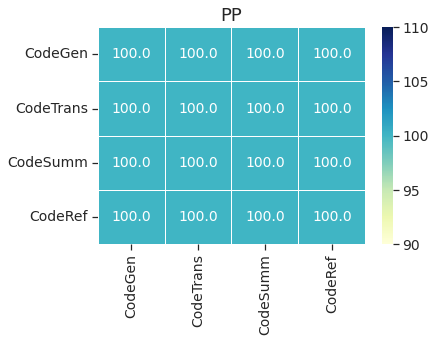

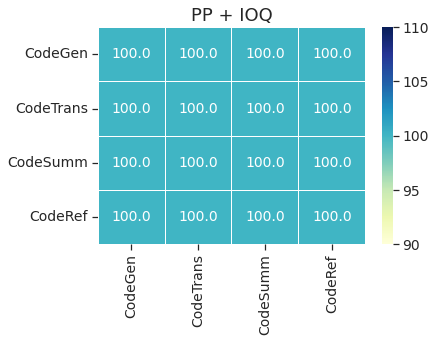

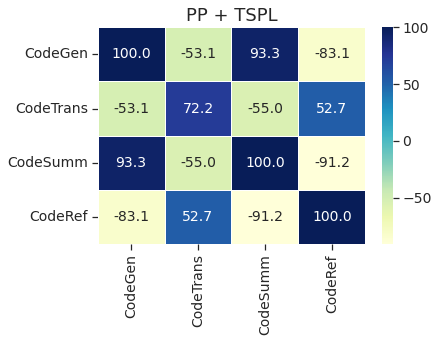

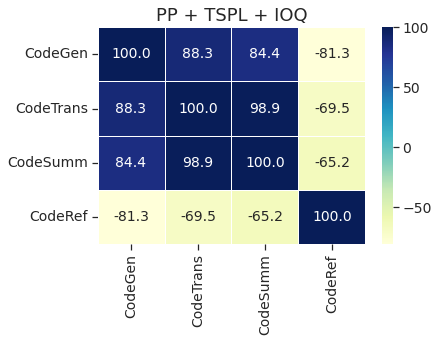

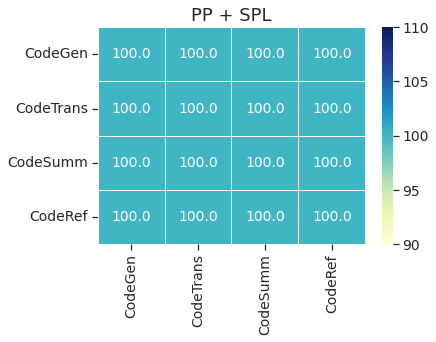

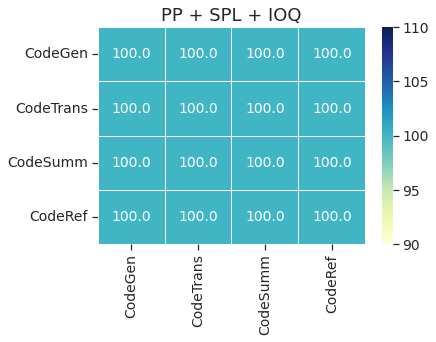

In [31]:
plot_heatmap(get_df(query_pool), title="PP", savename=None)
plot_heatmap(get_df(query_pool_io), title="PP + IOQ", savename=None)

plot_heatmap(get_df(query_pool_sep_proj), title="PP + TSPL", savename=None)
plot_heatmap(get_df(query_pool_io_sep_proj), title="PP + TSPL + IOQ", savename=None)

plot_heatmap(get_df(query_pool_shared_proj), title="PP + SPL", savename=None)
plot_heatmap(get_df(query_pool_io_shared_proj), title="PP + SPL + IOQ", savename=None)

In [42]:
counts_pool = {'Prompt_id' : list(range(60)),
'All': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
'CodeGen': [1000, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 1000, 0, 0, 0, 1000, 1000, 0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 0, 1000, 1000, 0, 0, 1000, 0],
'CodeTrans': [500, 0, 500, 500, 0, 0, 0, 0, 0, 0, 500, 0, 0, 500, 0, 0, 0, 500, 500, 0, 500, 0, 0, 500, 500, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 500, 0, 500, 500, 0, 0, 0, 500, 0, 0, 0, 500, 0, 0, 0, 500, 0, 0, 500, 500, 0, 0, 500, 0],
'CodeSumm': [1000, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 1000, 0, 0, 0, 1000, 1000, 0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 0, 1000, 1000, 0, 0, 1000, 0],
'CodeRef': [1000, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 1000, 0, 0, 0, 1000, 1000, 0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 0, 1000, 1000, 0, 0, 1000, 0],
}
counts_pool_shared_proj = {'Prompt_id' : list(range(60)),
'All': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
'CodeGen': [0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 0, 0, 1000, 0, 0, 0, 0, 1000, 0, 1000, 0, 0, 1000, 0, 1000, 0, 0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 1000, 1000, 0, 1000, 0, 0, 0, 0, 1000, 0, 0, 1000, 0],
'CodeTrans': [0, 500, 0, 0, 500, 500, 0, 0, 0, 0, 0, 500, 0, 0, 0, 500, 0, 500, 500, 0, 0, 500, 0, 0, 0, 0, 500, 0, 500, 0, 0, 500, 0, 500, 0, 0, 500, 0, 0, 500, 500, 0, 0, 0, 0, 0, 0, 500, 500, 0, 500, 0, 0, 0, 0, 500, 0, 0, 500, 0],
'CodeSumm': [0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 0, 0, 1000, 0, 0, 0, 0, 1000, 0, 1000, 0, 0, 1000, 0, 1000, 0, 0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 1000, 1000, 0, 1000, 0, 0, 0, 0, 1000, 0, 0, 1000, 0],
'CodeRef': [0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 0, 0, 1000, 0, 0, 0, 0, 1000, 0, 1000, 0, 0, 1000, 0, 1000, 0, 0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 1000, 1000, 0, 1000, 0, 0, 0, 0, 1000, 0, 0, 1000, 0],
}
counts_pool_sep_proj = {'Prompt_id' : list(range(60)),
'All': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
'CodeGen': [0, 1000, 0, 0, 1000, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 1000, 0, 0, 1000, 0, 0, 0, 0, 1000, 0, 1000, 1000, 1000, 0, 0, 0, 0, 1000, 0, 0, 1000, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 1000, 1000],
'CodeTrans': [65, 57, 374, 27, 55, 410, 418, 416, 400, 415, 57, 391, 34, 27, 53, 59, 34, 30, 45, 45, 30, 417, 412, 54, 415, 52, 61, 57, 419, 402, 17, 33, 52, 49, 54, 57, 418, 56, 28, 405, 414, 52, 28, 58, 42, 44, 410, 26, 423, 32, 419, 81, 27, 27, 38, 398, 56, 413, 56, 56],
'CodeSumm': [0, 1000, 0, 0, 1000, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 1000, 1000, 0, 0, 1000, 0, 0, 0, 0, 1000, 0, 1000, 1000, 1000, 0, 0, 0, 0, 1000, 0, 0, 1000, 0, 1000, 0, 0, 0, 1000, 0, 1000, 1000, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 1000, 1000],
'CodeRef': [0, 0, 1000, 0, 0, 1000, 1000, 1000, 1000, 1000, 0, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 1000, 0, 1000, 0, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 1000, 1000, 0, 0, 0, 0, 0, 1000, 0, 1000, 0, 1000, 0, 0, 0, 0, 1000, 0, 1000, 0, 0],
}


counts_pool_io = {'Prompt_id' : list(range(60)),
'All': [6777, 0, 0, 6622, 0, 838, 0, 0, 0, 1471, 6601, 1459, 1385, 6624, 1505, 6561, 0, 1477, 823, 0, 6556, 0, 1472, 6627, 6503, 1273, 0, 6638, 6519, 0, 1425, 1483, 0, 0, 1486, 0, 6548, 0, 6519, 1477, 85, 1364, 0, 7070, 1289, 1472, 6554, 1477, 0, 1117, 0, 6619, 6558, 6567, 1488, 7082, 6569, 0, 6509, 1511],
'CodeGen': [3170, 0, 0, 3015, 0, 0, 0, 0, 0, 453, 2994, 441, 367, 3017, 487, 2953, 0, 459, 0, 0, 2949, 0, 454, 3020, 2896, 255, 0, 3031, 2912, 0, 407, 465, 0, 0, 468, 0, 2941, 0, 2912, 459, 0, 346, 0, 3284, 271, 454, 2947, 459, 0, 99, 0, 3012, 2951, 2960, 549, 3287, 2961, 0, 2902, 493],
'CodeTrans': [2942, 0, 0, 2942, 0, 378, 0, 0, 0, 558, 2942, 558, 558, 2942, 558, 2943, 0, 558, 366, 0, 2942, 0, 558, 2942, 2942, 558, 0, 2942, 2942, 0, 558, 558, 0, 0, 558, 0, 2942, 0, 2942, 558, 38, 558, 0, 3121, 558, 558, 2942, 558, 0, 558, 0, 2942, 2942, 2942, 523, 3130, 2943, 0, 2942, 558],
'CodeSumm': [3165, 0, 0, 3165, 0, 460, 0, 0, 0, 460, 3165, 460, 460, 3165, 460, 3165, 0, 460, 457, 0, 3165, 0, 460, 3165, 3165, 460, 0, 3165, 3165, 0, 460, 460, 0, 0, 460, 0, 3165, 0, 3165, 460, 47, 460, 0, 3165, 460, 460, 3165, 460, 0, 460, 0, 3165, 3165, 3165, 416, 3165, 3165, 0, 3165, 460],
'CodeRef': [2102, 0, 0, 2102, 0, 273, 0, 0, 0, 273, 2102, 273, 273, 2102, 273, 2102, 0, 273, 273, 0, 2102, 0, 273, 2102, 2102, 273, 0, 2102, 2102, 0, 273, 273, 0, 0, 273, 0, 2102, 0, 2102, 273, 34, 273, 0, 2102, 273, 273, 2102, 255, 0, 273, 0, 2102, 2102, 2102, 257, 2102, 2102, 0, 2102, 273],
}
counts_pool_io_shared_proj = {'Prompt_id' : list(range(60)),
'All': [5840, 38, 2359, 2382, 5847, 5847, 5843, 58, 5842, 2371, 25, 81, 2373, 2355, 5834, 5806, 5840, 5844, 5847, 5842, 30, 2342, 38, 2359, 5800, 2378, 42, 2371, 2304, 24, 2369, 5847, 2346, 71, 2374, 44, 25, 2379, 50, 56, 2373, 5843, 5840, 97, 2372, 16, 5847, 5836, 35, 41, 5842, 2362, 47, 2355, 51, 5848, 72, 2380, 5841, 2379],
'CodeGen': [2694, 23, 643, 663, 2700, 2698, 2698, 41, 2696, 654, 17, 67, 656, 641, 2688, 2658, 2693, 2699, 2699, 2694, 24, 629, 22, 642, 2652, 663, 28, 653, 592, 19, 649, 2700, 633, 55, 662, 39, 9, 661, 34, 42, 657, 2697, 2695, 85, 655, 9, 2699, 2689, 19, 25, 2697, 654, 32, 646, 36, 2699, 55, 662, 2696, 663],
'CodeTrans': [2608, 10, 884, 887, 2608, 2609, 2607, 12, 2608, 885, 5, 9, 885, 880, 2607, 2609, 2608, 2607, 2609, 2609, 3, 881, 11, 885, 2609, 883, 9, 888, 879, 3, 888, 2608, 882, 11, 880, 3, 11, 887, 11, 9, 883, 2607, 2607, 10, 884, 4, 2608, 2608, 11, 11, 2607, 878, 10, 875, 10, 2609, 12, 888, 2607, 884],
'CodeSumm': [3038, 5, 832, 832, 3039, 3040, 3038, 5, 3038, 832, 3, 5, 832, 834, 3039, 3039, 3039, 3038, 3039, 3039, 3, 832, 5, 832, 3039, 832, 5, 830, 833, 2, 832, 3039, 831, 5, 832, 2, 5, 831, 5, 5, 833, 3039, 3038, 2, 833, 3, 3040, 3039, 5, 5, 3038, 830, 5, 834, 5, 3040, 5, 830, 3038, 832],
'CodeRef': [3660, 4, 1087, 1086, 3659, 3660, 3659, 4, 3659, 1087, 4, 4, 1088, 1087, 3659, 3658, 3657, 3659, 3659, 3659, 4, 1086, 4, 1088, 3657, 1086, 4, 1088, 1087, 2, 1086, 3658, 1087, 4, 1088, 2, 7, 1088, 4, 4, 1089, 3660, 3660, 2, 1088, 4, 3659, 3660, 4, 4, 3659, 1087, 4, 1085, 4, 3660, 4, 1088, 3659, 1087],
}
counts_pool_io_sep_proj = {'Prompt_id' : list(range(60)),
'All': [1804, 1763, 36, 6914, 48, 1776, 27, 25, 1803, 98, 6914, 61, 1799, 19, 6911, 1784, 6907, 6915, 46, 57, 1783, 63, 1778, 6923, 57, 6914, 1786, 27, 6917, 1791, 1740, 6926, 6929, 1806, 1798, 6928, 6927, 6927, 1779, 1758, 1801, 39, 6908, 6928, 6929, 6919, 1801, 35, 1806, 34, 1799, 24, 6923, 48, 17, 58, 6927, 1794, 6915, 31],
'CodeGen': [687, 648, 20, 3292, 26, 661, 8, 15, 686, 90, 3291, 53, 685, 6, 3292, 670, 3284, 3295, 32, 50, 668, 54, 665, 3302, 50, 3290, 675, 8, 3294, 677, 626, 3303, 3305, 688, 687, 3304, 3304, 3305, 667, 647, 686, 22, 3285, 3304, 3305, 3294, 687, 19, 687, 16, 680, 9, 3301, 44, 10, 50, 3304, 682, 3292, 13],
'CodeTrans': [553, 550, 8, 2818, 11, 550, 10, 4, 552, 2, 2820, 2, 549, 6, 2817, 549, 2820, 2817, 7, 2, 550, 6, 549, 2818, 2, 2818, 547, 10, 2818, 550, 550, 2819, 2820, 553, 549, 2820, 2820, 2820, 546, 548, 549, 8, 2819, 2820, 2820, 2820, 549, 8, 553, 10, 553, 8, 2819, 1, 4, 2, 2819, 548, 2820, 10],
'CodeSumm': [564, 565, 8, 3304, 11, 565, 9, 6, 565, 6, 3303, 6, 565, 7, 3302, 565, 3303, 3303, 7, 5, 565, 3, 564, 3303, 5, 3306, 564, 9, 3305, 564, 564, 3304, 3304, 565, 562, 3304, 3303, 3302, 566, 563, 566, 9, 3304, 3304, 3304, 3305, 565, 8, 566, 8, 566, 7, 3303, 3, 3, 6, 3304, 564, 3303, 8],
'CodeRef': [7, 6, 4054, 688, 4054, 14, 4055, 4050, 11, 4054, 690, 4053, 6, 4050, 690, 6, 690, 690, 4048, 4054, 6, 2, 6, 690, 4054, 690, 6, 4054, 691, 4056, 11, 690, 690, 7, 7, 689, 690, 689, 6, 16, 7, 4055, 690, 689, 688, 690, 4054, 4053, 7, 4054, 7, 4054, 689, 2, 4050, 4053, 688, 6, 690, 4054],
}

In [43]:
sparse_pool , dense_pool  = get_count_df(counts_pool , noise_perc_thresh=0.01, noise_exact_thresh=20)
sparse_pool_shared_proj , dense_pool_shared_proj  = get_count_df(counts_pool_shared_proj , noise_perc_thresh=0.01, noise_exact_thresh=20)
sparse_pool_sep_proj , dense_pool_sep_proj  = get_count_df(counts_pool_sep_proj , noise_perc_thresh=0.01, noise_exact_thresh=20)
sparse_pool_io , dense_pool_io  = get_count_df(counts_pool_io , noise_perc_thresh=0.01, noise_exact_thresh=20)
sparse_pool_io_shared_proj , dense_pool_io_shared_proj  = get_count_df(counts_pool_io_shared_proj , noise_perc_thresh=0.01, noise_exact_thresh=20)
sparse_pool_io_sep_proj , dense_pool_io_sep_proj  = get_count_df(counts_pool_io_sep_proj , noise_perc_thresh=0.01, noise_exact_thresh=20)

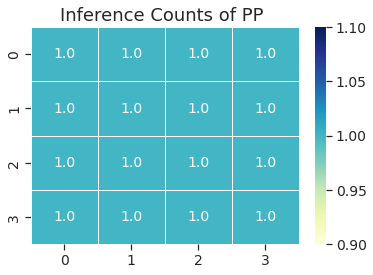

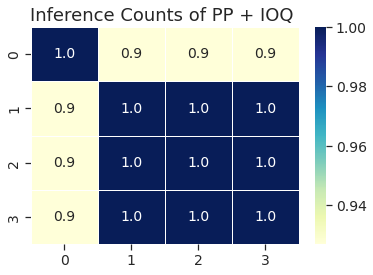

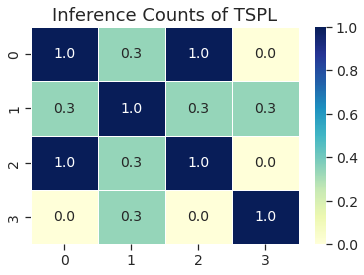

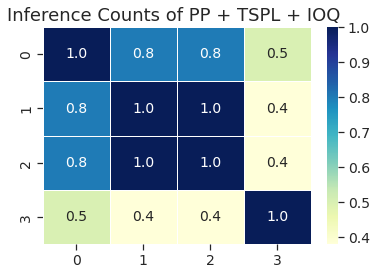

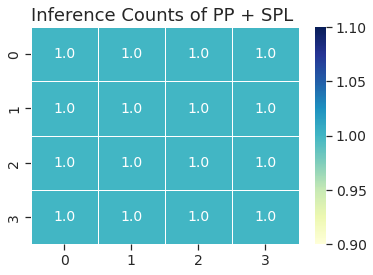

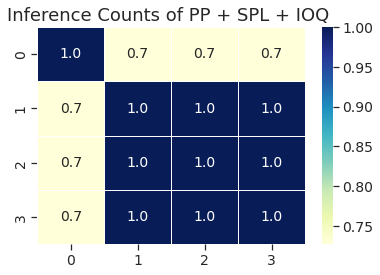

In [44]:
plot_heatmap(sparse_pool, title="Inference Counts of PP ", savename=None)
plot_heatmap(sparse_pool_io, title="Inference Counts of PP + IOQ ", savename=None)

plot_heatmap(sparse_pool_sep_proj, title="Inference Counts of TSPL", savename=None)
plot_heatmap(sparse_pool_io_sep_proj, title="Inference Counts of PP + TSPL + IOQ ", savename=None)

plot_heatmap(sparse_pool_shared_proj, title="Inference Counts of PP + SPL ", savename=None)
plot_heatmap(sparse_pool_io_shared_proj, title="Inference Counts of PP + SPL + IOQ ", savename=None)

In [8]:
query_mean_pool = np.array([[0.8563053607940674, 0.407372385263443, 0.4770825505256653, 0.4131416380405426], [0.4073724150657654, 0.5791868567466736, 0.3771502375602722, 0.3753919303417206], [0.4770825505256653, 0.3771502375602722, 0.6972495913505554, 0.5880584120750427], [0.4131416380405426, 0.3753919005393982, 0.5880584716796875, 0.8211775422096252]])
query_mean_pool_io = np.array([[0.8301857113838196, 0.5409269332885742, 0.543977677822113, 0.5576912760734558], [0.5409269332885742, 0.6860157251358032, 0.4461909234523773, 0.4751819968223572], [0.543977677822113, 0.44619089365005493, 0.7429189682006836, 0.6716530919075012], [0.5576912760734558, 0.47518205642700195, 0.6716530323028564, 0.8749330043792725]])


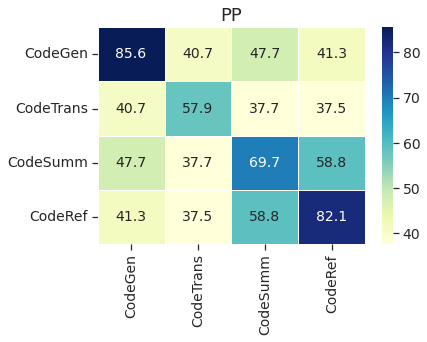

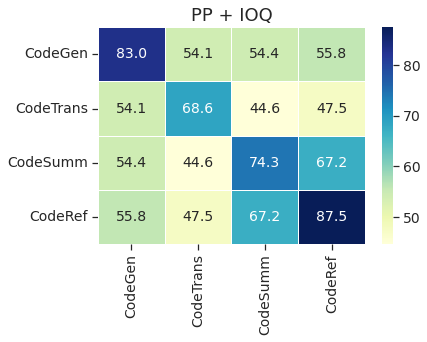

In [9]:
plot_heatmap(get_df(query_mean_pool), title="PP", savename=None)
plot_heatmap(get_df(query_mean_pool_io), title="PP + IOQ", savename=None)


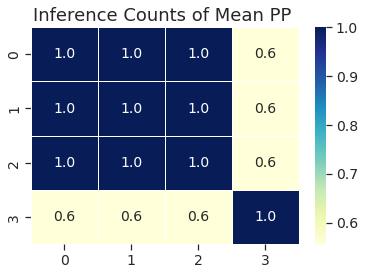

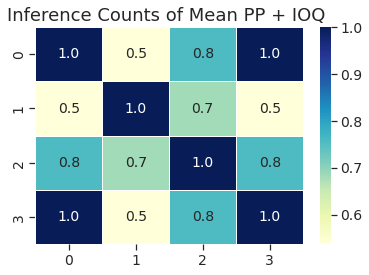

In [10]:
counts_mean_pool = {'Prompt_id' : list(range(60)),
'All': [0, 0, 47219, 54690, 24093, 101655, 0, 0, 0, 0, 47306, 47004, 0, 54626, 40002, 47258, 47148, 0, 0, 0, 24731, 0, 47260, 71099, 91923, 23732, 54556, 91489, 101575, 47362, 0, 0, 0, 91516, 47199, 40287, 54609, 0, 47021, 54602, 0, 55167, 55180, 39886, 0, 47002, 46973, 91562, 101601, 0, 40069, 0, 0, 46993, 54517, 0, 0, 0, 54828, 0],
'CodeGen': [0, 0, 1485, 45537, 15049, 46979, 0, 0, 0, 0, 1580, 1457, 0, 45572, 31072, 1532, 1467, 0, 0, 0, 15105, 0, 1533, 16425, 46398, 14799, 45576, 46308, 46897, 1627, 0, 0, 0, 46340, 1504, 31374, 45511, 0, 1467, 45572, 0, 45562, 45562, 30946, 0, 1448, 1455, 46421, 46923, 0, 31121, 0, 0, 1457, 45570, 0, 0, 0, 45549, 0],
'CodeTrans': [0, 0, 14776, 5937, 5829, 20391, 0, 0, 0, 0, 14898, 14588, 0, 5839, 5716, 14786, 14722, 0, 0, 0, 6409, 0, 14876, 20486, 14566, 5718, 5766, 14221, 20374, 14916, 0, 0, 0, 14216, 14736, 5699, 5883, 0, 14595, 5816, 0, 6389, 6402, 5725, 0, 14594, 14558, 14181, 20366, 0, 5733, 0, 0, 14577, 5733, 0, 0, 0, 6063, 0],
'CodeSumm': [0, 0, 33712, 4362, 4362, 38074, 0, 0, 0, 0, 33722, 33712, 0, 4362, 4362, 33712, 33712, 0, 0, 0, 4362, 0, 33712, 38074, 33712, 4362, 4362, 33712, 38064, 33730, 0, 0, 0, 33712, 33712, 4362, 4362, 0, 33712, 4362, 0, 4362, 4362, 4362, 0, 33712, 33712, 33712, 38056, 0, 4362, 0, 0, 33712, 4362, 0, 0, 0, 4362, 0],
'CodeRef': [0, 0, 29173, 0, 0, 29173, 0, 0, 0, 0, 29173, 29173, 0, 0, 0, 29173, 29173, 0, 0, 0, 0, 0, 29173, 29173, 29173, 0, 0, 29173, 29173, 29173, 0, 0, 0, 29173, 29173, 0, 0, 0, 29173, 0, 0, 0, 0, 0, 0, 29173, 29173, 29173, 29173, 0, 0, 0, 0, 29173, 0, 0, 0, 0, 0, 0],    
}

counts_mean_pool_io = {
'Prompt_id' : list(range(60)),
'All': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
'CodeGen': [1844, 0, 154, 1845, 0, 0, 0, 0, 0, 1846, 2000, 2000, 59, 155, 155, 152, 1847, 0, 0, 0, 1845, 0, 2000, 154, 0, 2000, 155, 0, 0, 154, 0, 0, 0, 1845, 155, 153, 0, 0, 2000, 1944, 0, 1846, 1844, 0, 59, 2000, 1944, 1846, 1846, 0, 154, 0, 1846, 0, 2000, 0, 0, 0, 0, 153],
'CodeTrans': [493, 0, 7, 493, 123, 0, 0, 0, 0, 493, 376, 376, 320, 7, 7, 6, 493, 0, 0, 0, 493, 0, 376, 7, 124, 376, 7, 124, 0, 7, 0, 0, 0, 493, 7, 6, 123, 0, 377, 144, 0, 493, 493, 124, 249, 414, 144, 493, 493, 0, 7, 0, 493, 109, 376, 0, 0, 123, 124, 7],
'CodeSumm': [426, 0, 967, 419, 182, 0, 0, 0, 0, 420, 1231, 1231, 1, 971, 972, 972, 417, 0, 0, 0, 419, 0, 1231, 964, 182, 1231, 967, 184, 0, 967, 0, 0, 0, 418, 975, 968, 182, 0, 1231, 1348, 0, 425, 425, 183, 1, 1230, 1287, 421, 419, 0, 966, 0, 420, 173, 1240, 0, 0, 180, 182, 972],
'CodeRef': [1700, 0, 4133, 1691, 0, 0, 0, 0, 0, 1702, 5835, 5835, 631, 4141, 4144, 4128, 1699, 0, 0, 0, 1689, 0, 5835, 4132, 0, 5835, 4133, 0, 0, 4133, 0, 0, 0, 1691, 4144, 4139, 0, 0, 5835, 5219, 0, 1702, 1699, 0, 632, 5835, 5220, 1702, 1695, 0, 4133, 0, 1702, 0, 5835, 0, 0, 0, 0, 4121],
}

sparse_mean_pool , dense_mean_pool  = get_count_df(counts_mean_pool , noise_perc_thresh=0.01, noise_exact_thresh=20)
sparse_mean_pool_io , dense_mean_pool_io = get_count_df(counts_mean_pool_io , noise_perc_thresh=0.01, noise_exact_thresh=20)

plot_heatmap(sparse_mean_pool, title="Inference Counts of Mean PP ", savename=None)
plot_heatmap(sparse_mean_pool_io, title="Inference Counts of Mean PP + IOQ ", savename=None)


In [4]:
query_sim = np.array([[0.7242346405982971, 0.7096769213676453, 0.7375187277793884, 0.7114068865776062], [0.7096769213676453, 0.6964110136032104, 0.722263753414154, 0.6979164481163025], [0.7375186681747437, 0.722263753414154, 0.7519566416740417, 0.7242268919944763], [0.7114068269729614, 0.6979164481163025, 0.7242268919944763, 0.6997007131576538]])
query_projected_sim = np.array([[0.7880422472953796, 0.5574225187301636, 0.505427896976471, 0.4722161591053009], [0.5574225783348083, 0.7157254815101624, 0.6453919410705566, 0.5929977893829346], [0.505427896976471, 0.6453919410705566, 0.7573404908180237, 0.6974706649780273], [0.4722161293029785, 0.5929977297782898, 0.6974706649780273, 0.7609748244285583]])

sim_df = get_df(query_sim)
proj_sim_df = get_df(query_projected_sim)

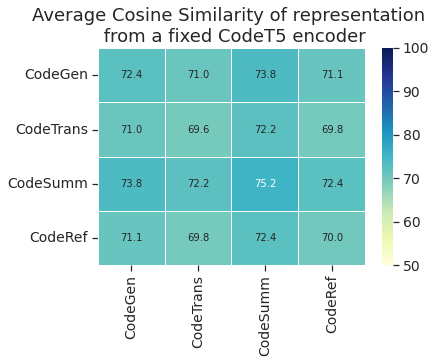

In [5]:
#### Conicity heatmap without projection layers and fixed codeT5 encoder.
plot_heatmap(sim_df, title="Average Cosine Similarity of representation \n from a fixed CodeT5 encoder", savename="sim")

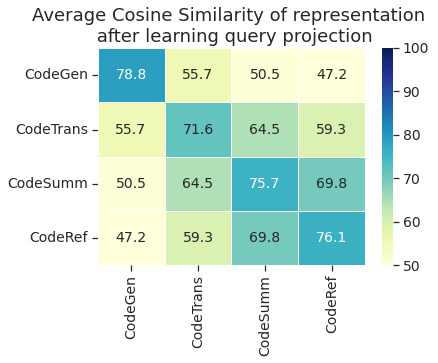

In [6]:
#### Conicity heatmap after projection layers
plot_heatmap(proj_sim_df, title="Average Cosine Similarity of representation \n after learning query projection", savename="proj_sim")

## Prompt Frequency analysis

In [32]:
norm_freq_counts = {
    "Prompt_id" : list(range(60)),
    'All': [3337, 3341, 2898, 1840, 1119, 1808, 3232, 3316, 0, 3247, 3032, 2000, 3685, 1659, 1805, 1996, 3665, 3772, 3603, 3237, 1309, 3341, 3341, 3232, 3532, 1493, 3620, 3231, 3341, 3199, 3201, 3681, 3341, 2859, 3713, 3659, 3777, 1828, 3244, 1450, 3698, 3688, 1847, 3203, 3699, 3656, 3206, 3682, 1999, 2848, 1179, 3693, 2833, 1182, 1751, 2003, 0, 2871, 3179, 1799],
    "CodeGen" : [3337, 0, 48, 0, 479, 0, 95, 0, 0, 51, 14, 0, 3685, 0, 0, 0, 3665, 3748, 3603, 3230, 669, 0, 0, 49, 3532, 0, 3620, 220, 0, 51, 51, 3681, 0, 48, 3713, 3659, 3750, 0, 3229, 0, 3698, 3688, 0, 55, 3664, 3656, 64, 3682, 0, 160, 539, 3693, 141, 542, 0, 0, 0, 35, 3156, 0],
    "CodeTrans" : [0, 1352, 191, 1360, 0, 1312, 23, 819, 0, 106, 533, 1375, 0, 1163, 1352, 1375, 0, 0, 0, 7, 0, 1352, 1352, 78, 0, 985, 0, 1, 1352, 29, 26, 0, 1352, 147, 0, 0, 0, 1352, 15, 1352, 0, 0, 1367, 24, 0, 0, 23, 0, 1375, 23, 0, 0, 23, 0, 1255, 1375, 0, 348, 23, 1303],
    "CodeSumm" : [0, 0, 611, 16, 129, 496, 625, 508, 0, 614, 496, 117, 0, 496, 0, 113, 0, 0, 0, 0, 129, 0, 0, 625, 0, 508, 0, 527, 0, 625, 625, 0, 0, 625, 0, 0, 0, 14, 0, 98, 0, 0, 16, 625, 1, 0, 624, 0, 117, 625, 129, 0, 625, 129, 496, 121, 0, 499, 0, 496],
    "CodeRef" : [0, 1989, 2048, 464, 511, 0, 2489, 1989, 0, 2476, 1989, 508, 0, 0, 453, 508, 0, 24, 0, 0, 511, 1989, 1989, 2480, 0, 0, 0, 2483, 1989, 2494, 2499, 0, 1989, 2039, 0, 0, 27, 462, 0, 0, 0, 0, 464, 2499, 34, 0, 2495, 0, 507, 2040, 511, 0, 2044, 511, 0, 507, 0, 1989, 0, 0],
}

freq_counts = {
    "Prompt_id" : list(range(60)),
    "All" : [9540, 0, 1468, 0, 1901, 0, 1517, 0, 0, 1472, 1431, 0, 9888, 0, 1377, 0, 9870, 9957, 9806, 9436, 2091, 0, 0, 1470, 9735, 0, 9825, 1642, 0, 1473, 1472, 9885, 0, 1468, 9916, 9862, 9959, 0, 9432, 0, 9901, 9892, 0, 1477, 9879, 9900, 1486, 9886, 0, 1582, 1961, 9896, 1563, 1964, 0, 1407, 0, 1454, 9359, 0],
    "CodeGen" : [3337, 0, 48, 0, 479, 0, 95, 0, 0, 51, 14, 0, 3685, 0, 0, 0, 3665, 3748, 3603, 3230, 669, 0, 0, 49, 3532, 0, 3620, 220, 0, 51, 51, 3681, 0, 48, 3713, 3659, 3750, 0, 3229, 0, 3698, 3688, 0, 55, 3664, 3656, 64, 3682, 0, 160, 539, 3693, 141, 542, 0, 0, 0, 35, 3156, 0],
    "CodeTrans" : [3272, 0, 726, 0, 728, 0, 728, 0, 0, 727, 723, 0, 3272, 0, 683, 0, 3274, 3278, 3272, 3275, 728, 0, 0, 727, 3272, 0, 3274, 728, 0, 728, 727, 3273, 0, 726, 3272, 3272, 3278, 0, 3272, 0, 3272, 3273, 0, 728, 3284, 3313, 728, 3273, 0, 728, 728, 3272, 728, 728, 0, 713, 0, 725, 3272, 0],
    "CodeSumm" : [1309, 0, 316, 0, 316, 0, 316, 0, 0, 316, 316, 0, 1309, 0, 316, 0, 1309, 1309, 1309, 1309, 316, 0, 0, 316, 1309, 0, 1309, 316, 0, 316, 316, 1309, 0, 316, 1309, 1309, 1309, 0, 1309, 0, 1309, 1309, 0, 316, 1309, 1309, 316, 1309, 0, 316, 316, 1309, 316, 316, 0, 316, 0, 316, 1309, 0],
    "CodeRef" : [1622, 0, 378, 0, 378, 0, 378, 0, 0, 378, 378, 0, 1622, 0, 378, 0, 1622, 1622, 1622, 1622, 378, 0, 0, 378, 1622, 0, 1622, 378, 0, 378, 378, 1622, 0, 378, 1622, 1622, 1622, 0, 1622, 0, 1622, 1622, 0, 378, 1622, 1622, 378, 1622, 0, 378, 378, 1622, 378, 378, 0, 378, 0, 378, 1622, 0],
}

In [36]:
(sparse_freq_overlap, dense_freq_overlap) = get_intersection_stats(freq_counts, noise_perc_thresh=0.01, noise_exact_thresh=0)
print(sparse_freq_overlap)
print(dense_freq_overlap)
sparse_freq_overlap_df = get_df(sparse_freq_overlap)
dense_freq_overlap_df = get_df(dense_freq_overlap)

[[1.   0.95 0.95 0.95]
 [0.95 1.   1.   1.  ]
 [0.95 1.   1.   1.  ]
 [0.95 1.   1.   1.  ]]
[[0.63333333 0.63333333 0.63333333 0.63333333]
 [0.63333333 0.66666667 0.66666667 0.66666667]
 [0.63333333 0.66666667 0.66666667 0.66666667]
 [0.63333333 0.66666667 0.66666667 0.66666667]]


In [37]:
(sparse_norm_freq_overlap, dense_norm_freq_overlap) = get_intersection_stats(norm_freq_counts, noise_perc_thresh=0.01, noise_exact_thresh=0)
print(sparse_norm_freq_overlap)
print(dense_norm_freq_overlap)

sparse_norm_freq_overlap_df = get_df(sparse_norm_freq_overlap)
dense_norm_freq_overlap_df = get_df(dense_norm_freq_overlap)

[[1.         0.29310345 0.36538462 0.40384615]
 [0.29310345 1.         0.66666667 0.63636364]
 [0.36538462 0.66666667 1.         0.65853659]
 [0.40384615 0.63636364 0.65853659 1.        ]]
[[0.63333333 0.28333333 0.31666667 0.35      ]
 [0.28333333 0.61666667 0.46666667 0.46666667]
 [0.31666667 0.46666667 0.55       0.45      ]
 [0.35       0.46666667 0.45       0.58333333]]


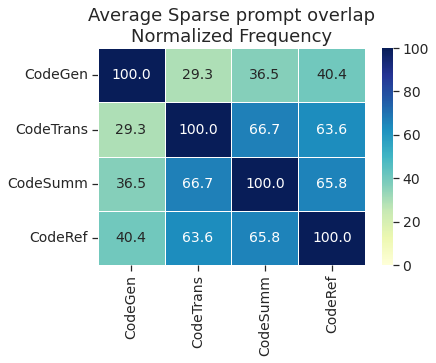

In [38]:
plot_heatmap(sparse_norm_freq_overlap_df, title="Average Sparse prompt overlap\nNormalized Frequency", savename="prompt_sparse_overlap_norm_freq", vmin=0, vmax=100)

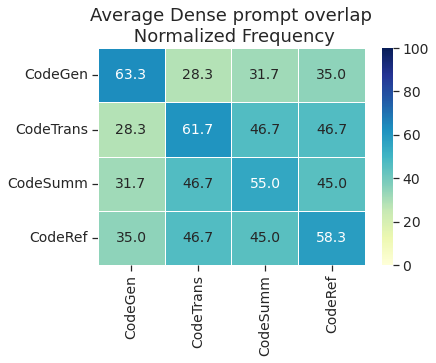

In [39]:
plot_heatmap(dense_norm_freq_overlap_df, title="Average Dense prompt overlap\n Normalized Frequency", savename="prompt_dense_overlap_norm_freq", vmin=0, vmax=100)

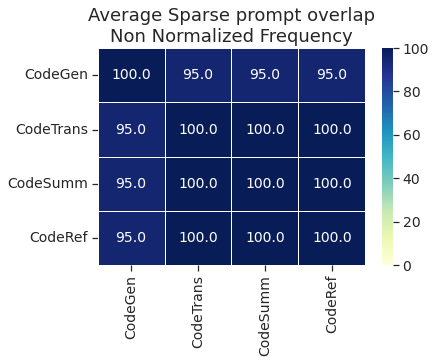

In [40]:
plot_heatmap(sparse_freq_overlap_df, title="Average Sparse prompt overlap\nNon Normalized Frequency", savename="prompt_dense_overlap_norm_freq", vmin=0, vmax=100)

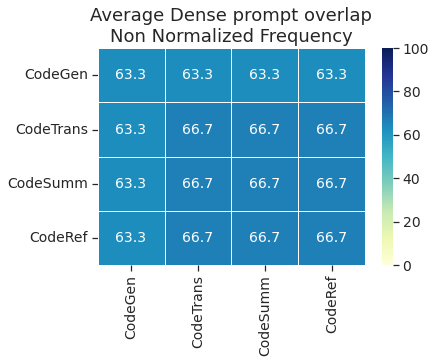

In [41]:
plot_heatmap(dense_freq_overlap_df, title="Average Dense prompt overlap\nNon Normalized Frequency", savename="prompt_dense_overlap_freq", vmin=0, vmax=100)

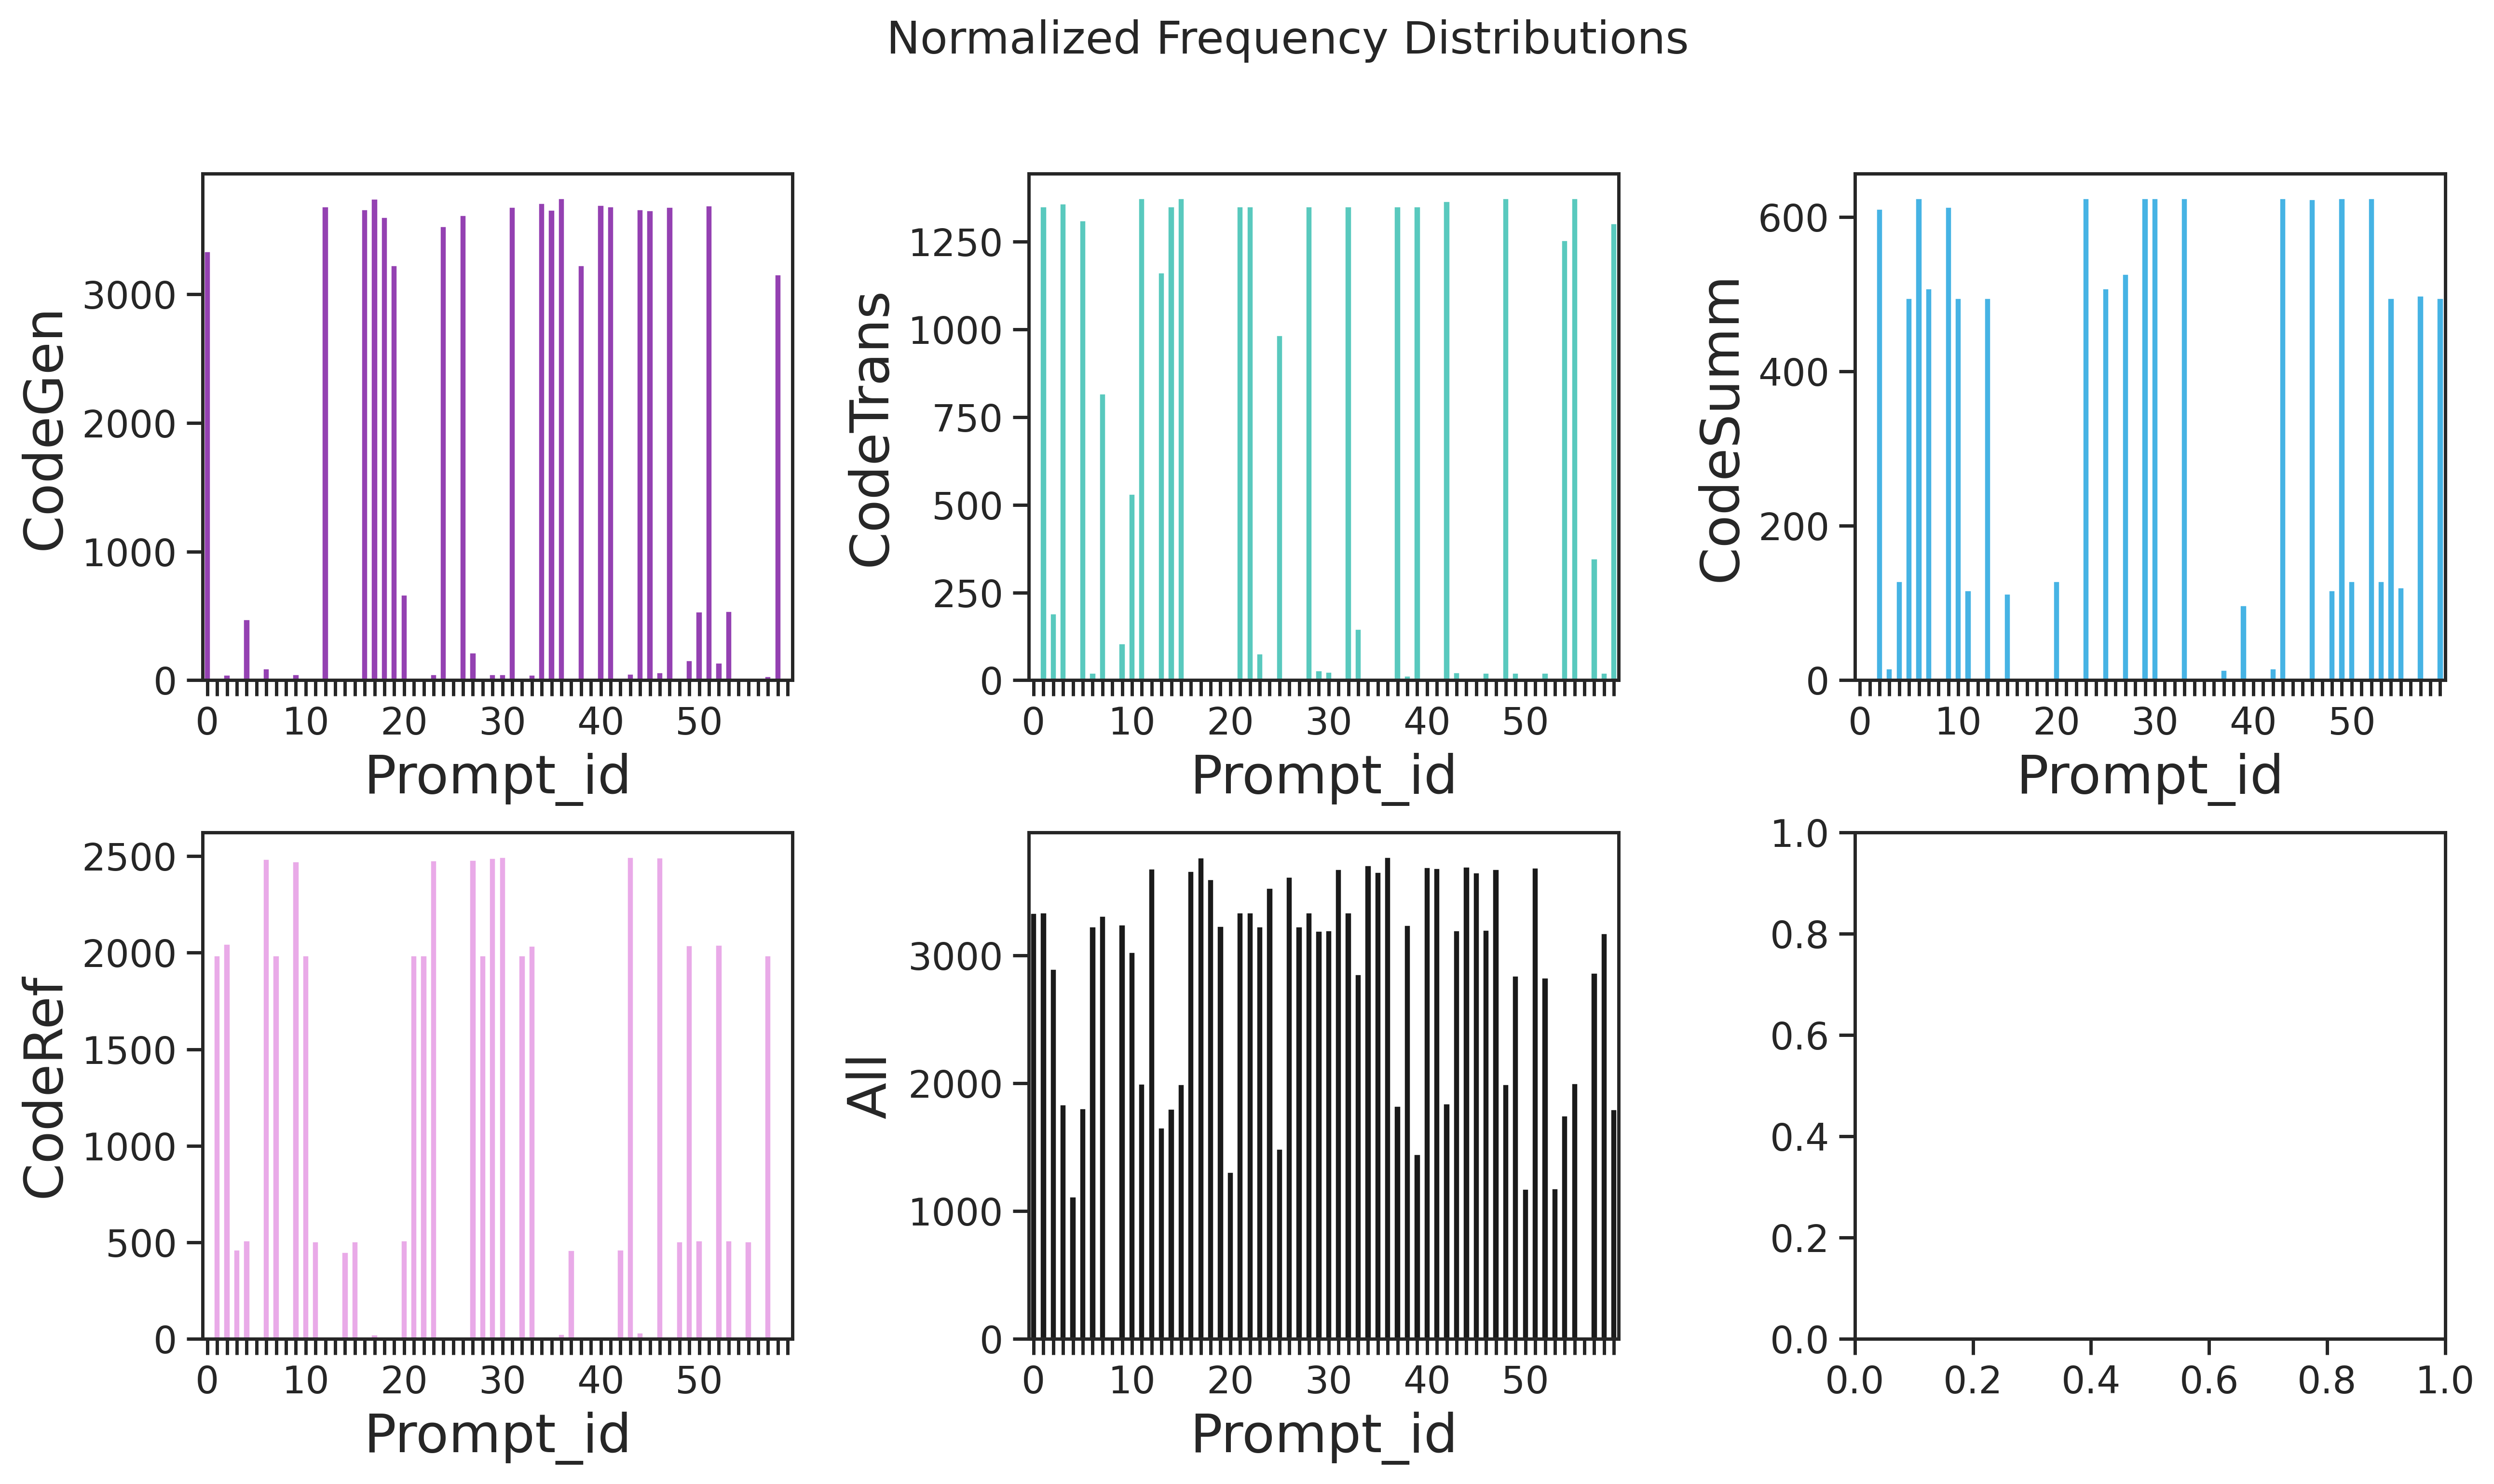

In [16]:
columns = ['CodeGen','CodeTrans','CodeSumm','CodeRef']
norm_freq_df = pd.DataFrame.from_dict(norm_freq_counts)
plot_freq_counts(norm_freq_df, title='Normalized Frequency Distributions', savename='norm_freq_counts')

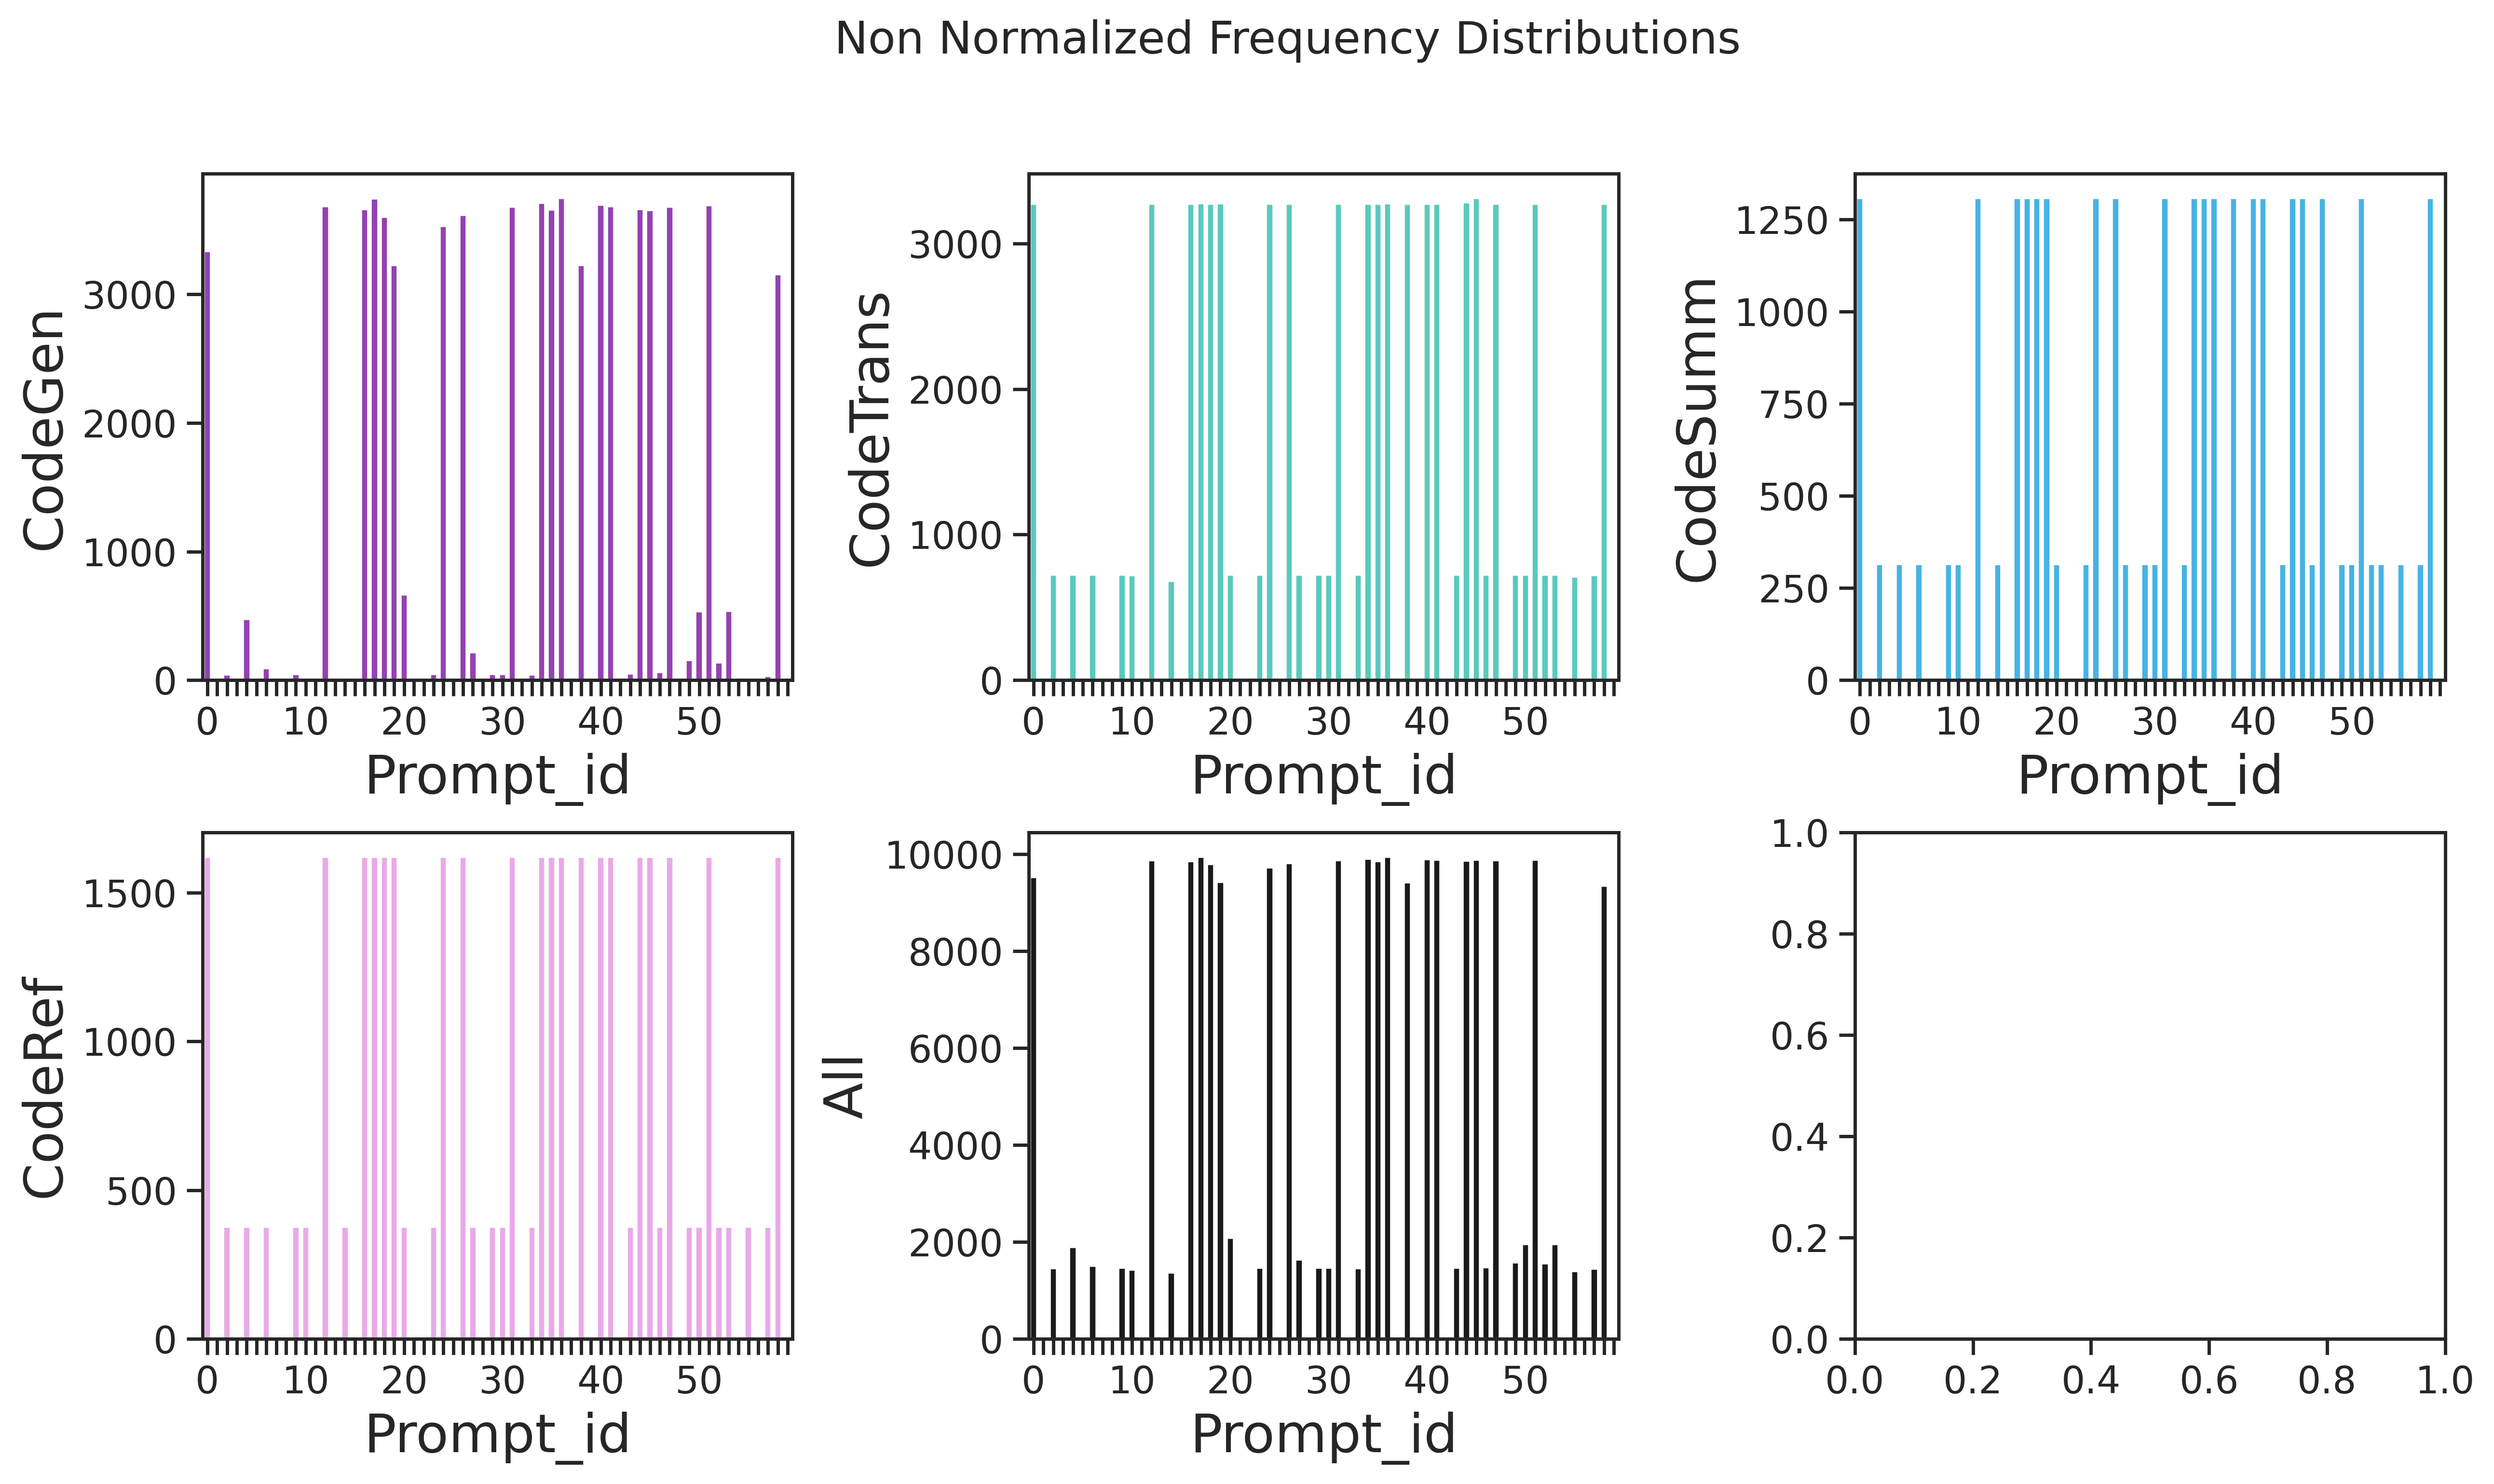

In [17]:
columns = ['CodeGen','CodeTrans','CodeSumm','CodeRef']
freq_df = pd.DataFrame.from_dict(freq_counts)
plot_freq_counts(freq_df, title='Non Normalized Frequency Distributions', savename='freq_counts')